<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [2]:
# Загружу данные, выведу первые строки и информацию
data = pd.read_csv('/datasets/taxi.csv',index_col=[0],parse_dates=[0])
data.sort_index(inplace=True)
display(data.head())
data.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


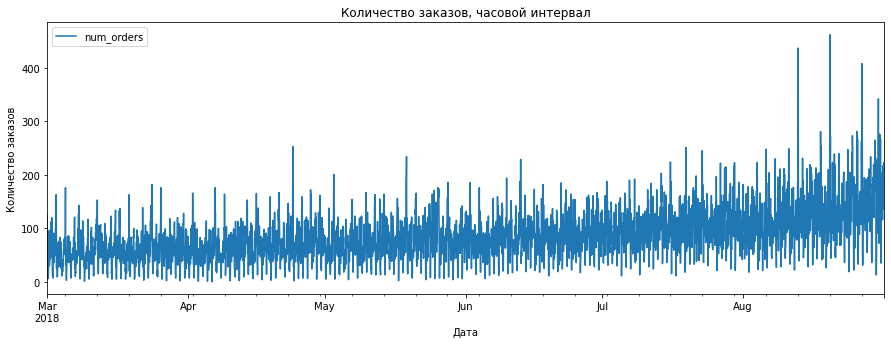

In [3]:
# Сделаю ресэмплирование по 1 часу
data = data .resample('1H').sum()
data.plot(figsize=(15,5))
plt.title('Количество заказов, часовой интервал')
plt.xlabel('Дата')
plt.ylabel('Количество заказов');

Данные представлены периодом с начала марта по конец августа 2018 года.
Формат индекса я установил, num_orders тоже в правильном формате.

## Анализ

In [4]:
# Посмотрю информацию по данным
print('Дата начала:',data.index.min())
print('Дата конца:',data.index.max())
print('Общий интервал:',data.index.max() - data.index.min())

data.describe()

Дата начала: 2018-03-01 00:00:00
Дата конца: 2018-08-31 23:00:00
Общий интервал: 183 days 23:00:00


,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


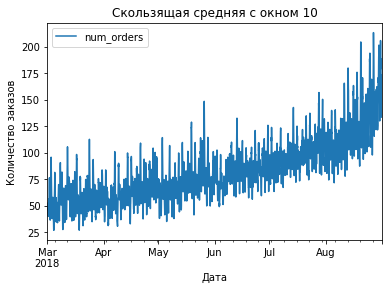

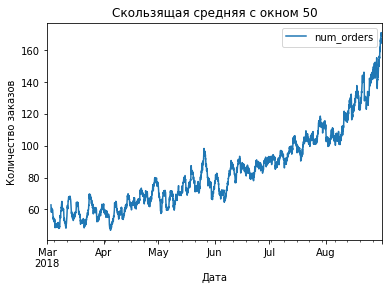

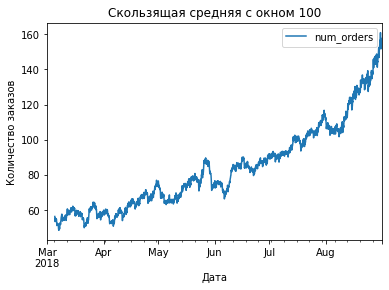

In [5]:
# Посмотрю на скользящую среднюю с разными параметрами
for i in [10,50,100]:
    data.rolling(i,closed='left').mean().plot()
    plt.title('Скользящая средняя с окном {}'.format(i))
    plt.xlabel('Дата')
    plt.ylabel('Количество заказов');

Данные имеют восходящий тренд.

Теперь проведу анализ временных рядов.

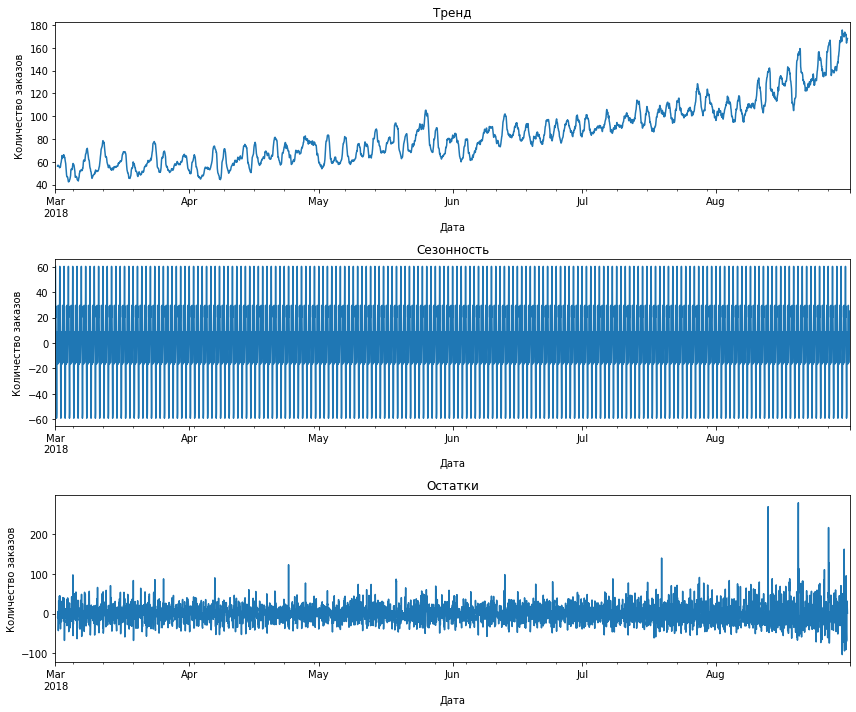

In [6]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(12, 10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Дата')
plt.ylabel('Количество заказов');

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Дата')
plt.ylabel('Количество заказов');

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.xlabel('Дата')
plt.ylabel('Количество заказов');
plt.tight_layout()

Графики показывают высокую частотность и суточную сезонность. Чтобы проследить более наглядно, возьму интервал неделю и посмотрю те же самые графики.

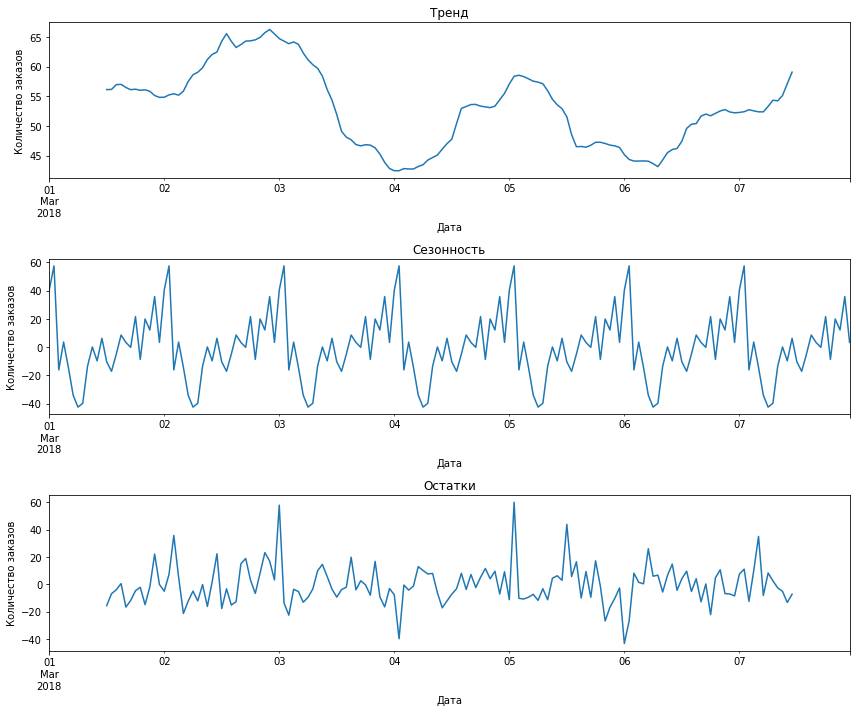

In [7]:
decomposed = seasonal_decompose(data['2018-03-01':'2018-03-07'])

plt.figure(figsize=(12, 10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Дата')
plt.ylabel('Количество заказов');

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Дата')
plt.ylabel('Количество заказов');

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.xlabel('Дата')
plt.ylabel('Количество заказов');
plt.tight_layout()

Теперь явно видна суточная сезонность. Ночью количество заказов стремится к нулю, а с началом вечернего часа пик число заказов возрастает и достигает своего пика.

Посмотрю на график скользящей средней и график скользящего стандартного отклонения.

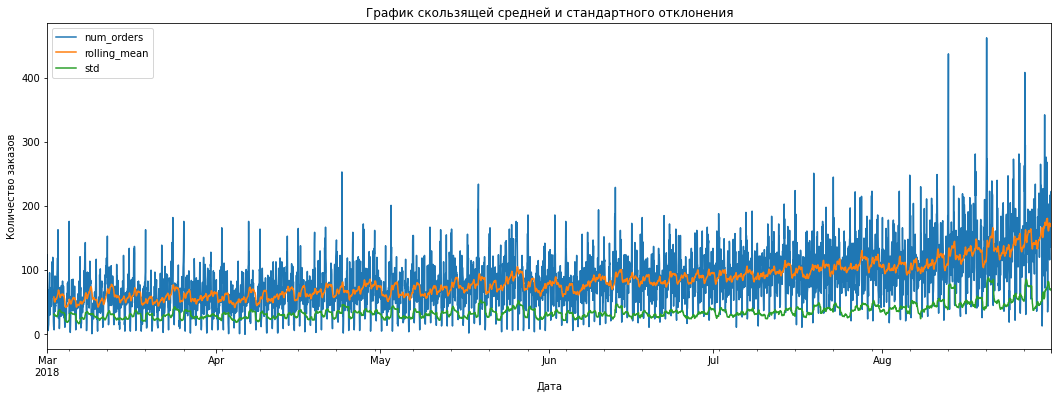

In [8]:
data_rol = data.copy()
data_rol['rolling_mean'] = data_rol.rolling(30,closed='left').mean()
data_rol['std'] = data_rol['num_orders'].rolling(30,closed='left').std()
data_rol.plot(figsize=(18, 6))
plt.xlabel('Дата')
plt.ylabel('Количество заказов');
plt.title('График скользящей средней и стандартного отклонения');

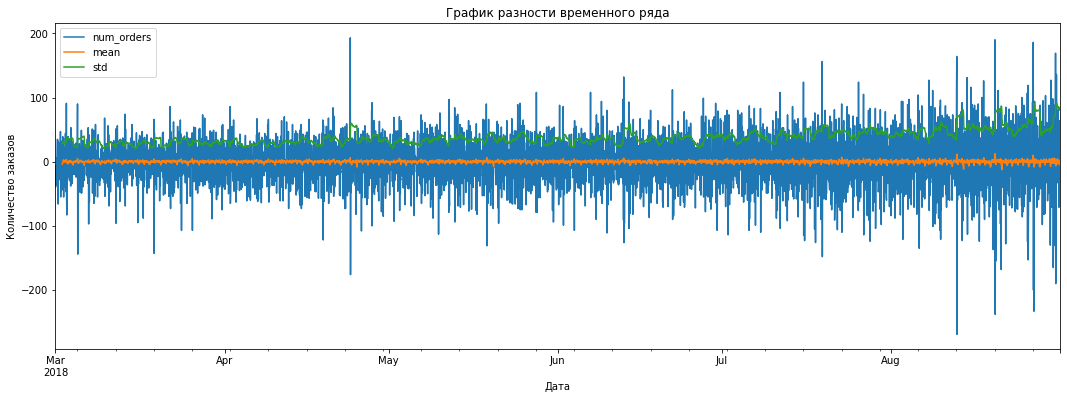

In [9]:
data_shift = data - data.shift()
data_shift['mean'] = data_shift['num_orders'].rolling(30).mean()
data_shift['std'] = data_shift['num_orders'].rolling(30).std()
data_shift.plot(figsize=(18, 6))
plt.xlabel('Дата')
plt.ylabel('Количество заказов');
plt.title('График разности временного ряда');

Разности временного ряда более стационарны, чем сам ряд. Это видно на графиках сверху - график скользящих нестационарен, имеется тенденция вверх. А уже график разности более стационарен.


**Вывод**

Методом декомпозиции были выделены следующие аспекты:

- За время всех наблюдений наметился восходящий тренд на общее увеличение числа заказов такси в течение часа. Это может быть вызвано общим ростом количества заказов, то есть развитием компании.Однако проверить это можно только имея данные за несколько лет.
- На графиках явно видна суточная сезонность. Ночью количество заказов стремится к нулю, в то время как вечерний час пик - момент самого сильного спроса на услуги такси.

## Обучение

Обучу четыре модели с оценкой их качества метрикой RMSE. В качестве моделей использую Линейную регрессию, Случайный лес, CatBoostRegressor и LGBM.

Сделаю функцию для создания признаков - день недели, час, отстающие значения и скользящее среднее.

In [10]:
def make_features(data, max_lag, rolling_mean_size):
    data_new = data.copy()
    data_new['dayofweek'] = data_new.index.dayofweek
    data_new['hour'] = data_new.index.hour
    
    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format(lag)] = data_new['num_orders'].shift(lag)

    data_new['rolling_mean'] = data_new['num_orders'].shift().rolling(rolling_mean_size).mean()
    data_new = data_new.dropna()
    return data_new

In [11]:
# Применю функцию с лагом до 24 часов и 100-м скользящим средним
data_new = make_features(data,24,100)
data_new = data_new.dropna()
data_new.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-05 04:00:00,34,0,4,51.0,32.0,176.0,86.0,68.0,83.0,75.0,...,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,27.0,56.46
2018-03-05 05:00:00,16,0,5,34.0,51.0,32.0,176.0,86.0,68.0,83.0,...,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,55.56
2018-03-05 06:00:00,3,0,6,16.0,34.0,51.0,32.0,176.0,86.0,68.0,...,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,54.87
2018-03-05 07:00:00,14,0,7,3.0,16.0,34.0,51.0,32.0,176.0,86.0,...,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,54.19
2018-03-05 08:00:00,31,0,8,14.0,3.0,16.0,34.0,51.0,32.0,176.0,...,64.0,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,53.67


In [12]:
# Разделю данные на обучающую и тестовую выборки
train, test = train_test_split(data_new, shuffle=False, test_size=0.1)

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(3884, 27)
(432, 27)
(3884,)
(432,)


In [13]:
# Создаю функцию для метрики RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Создаю объект-скорер для RMSE
scorer = make_scorer(rmse, greater_is_better=False)

**Линейная регрессия**

In [14]:
# Создаю регрессор
regressor = LinearRegression()

# Определяю гиперпараметры для поиска
hyperparams = {}

# Функция TimeSeriesSplit для применения внутри кросс-валидации
cv_ts = TimeSeriesSplit(n_splits=3).split(features_train)

# Создаю GridSearchCV
clf = GridSearchCV(regressor, hyperparams, scoring=scorer, return_train_score=True,cv=cv_ts)

# Обучаю модель и выполняю кросс-валидацию
clf.fit(features_train, target_train)

# Извлекаю результаты из cv_results_
results = clf.cv_results_

# Извлекаю лучшие параметры и RMSE
best_params = clf.best_params_
best_rmse_LR = -clf.best_score_

# Извлекаю время обучения и предсказания из cv_results_
mean_fit_time_LR = results['mean_fit_time']
mean_score_time_LR = results['mean_score_time']

# Вывод результатов
print("Лучшие параметры:")
print(best_params)
print()
print("Лучшее RMSE:", best_rmse_LR)
print()
print("Среднее время обучения (сек):", mean_fit_time_LR)
print("Среднее время предсказания (сек):", mean_score_time_LR)

Лучшие параметры:
{}

Лучшее RMSE: 28.412402437142486

Среднее время обучения (сек): [0.07154648]
Среднее время предсказания (сек): [0.11355178]


**DecissionTree регрессия**

In [15]:
# Создаю регрессор и список значений max_depth
regressor = DecisionTreeRegressor(criterion='mse',random_state=42)
max_depth_list = [x for x in range(2, 10)]

# Задаем гиперпараметры для GridSearchCV
hyperparams = [{'max_depth': max_depth_list}]

# Функция TimeSeriesSplit для применения внутри кросс-валидации
cv_ts = TimeSeriesSplit(n_splits=3).split(features_train)

In [16]:
# Создаем GridSearchCV
clf = GridSearchCV(regressor, hyperparams, scoring=scorer, return_train_score=True,cv=cv_ts)

# Обучаем модель и выполняем кросс-валидацию
clf.fit(features_train, target_train)

# Извлекаем результаты из cv_results_
results = clf.cv_results_

# Извлекаем лучшие параметры и RMSE
best_params = clf.best_params_
best_rmse_DT = -clf.best_score_

# Извлекаем время обучения и предсказания из cv_results_
mean_fit_time_DT = results['mean_fit_time']
mean_score_time_DT = results['mean_score_time']

# Выводим результаты
print("Лучшие параметры:")
print(best_params)
print()
print("Лучшее RMSE:", best_rmse_DT)
print()
print("Среднее время обучения (сек):", mean_fit_time_DT)
print("Среднее время предсказания (сек):", mean_score_time_DT)

Лучшие параметры:
{'max_depth': 5}

Лучшее RMSE: 30.910303928785726

Среднее время обучения (сек): [0.00887664 0.01038218 0.01517073 0.0170265  0.02083087 0.02338902
 0.02497904 0.02705145]
Среднее время предсказания (сек): [0.00193636 0.00192507 0.00181866 0.00209014 0.00265662 0.0023342
 0.0021855  0.00210627]


**Регрессия CatBoostRegressor**

In [17]:
# Создаю регрессор
regressor = CatBoostRegressor(verbose=False,random_state=42) 
hyperparams = [{'learning_rate':[0.3, 0.6]}]

# Функция TimeSeriesSplit для применения внутри кросс-валидации
cv_ts = TimeSeriesSplit(n_splits=3).split(features_train)

# Создаем GridSearchCV
clf = GridSearchCV(regressor, hyperparams, scoring=scorer, return_train_score=True,cv=cv_ts)

# Обучаем модель и выполняем кросс-валидацию
clf.fit(features_train, target_train)

# Извлекаем результаты из cv_results_
results = clf.cv_results_

# Извлекаем лучшие параметры и RMSE
best_params = clf.best_params_
best_rmse_CB = -clf.best_score_

# Извлекаем время обучения и предсказания из cv_results_
mean_fit_time_CB = results['mean_fit_time']
mean_score_time_CB = results['mean_score_time']

# Выводим результаты
print("Лучшие параметры:")
print(best_params)
print()
print("Лучшее RMSE:", best_rmse_CB)
print()
print("Среднее время обучения (сек):", mean_fit_time_CB)
print("Среднее время предсказания (сек):", mean_score_time_CB)

Лучшие параметры:
{'learning_rate': 0.3}

Лучшее RMSE: 27.124549129866143

Среднее время обучения (сек): [5.155984   5.22908894]
Среднее время предсказания (сек): [0.00391412 0.00363612]


**Регрессия LGBM**

In [18]:
regressor = LGBMRegressor(learning_rate=0.3,random_state=42) 
hyperparams = [{'num_leaves':[11, 50, 100]}]

# Функция TimeSeriesSplit для применения внутри кросс-валидации
cv_ts = TimeSeriesSplit(n_splits=3).split(features_train)

# Создаем GridSearchCV
clf = GridSearchCV(regressor, hyperparams, scoring=scorer, return_train_score=True,cv=cv_ts)

# Обучаем модель и выполняем кросс-валидацию
clf.fit(features_train, target_train)

# Извлекаем результаты из cv_results_
results = clf.cv_results_

# Извлекаем лучшие параметры и RMSE
best_params = clf.best_params_
best_rmse_LGBM = -clf.best_score_

# Извлекаем время обучения и предсказания из cv_results_
mean_fit_time_LGBM = results['mean_fit_time']
mean_score_time_LGBM = results['mean_score_time']

# Выводим результаты
print("Лучшие параметры:")
print(best_params)
print()
print("Лучшее RMSE:", best_rmse_LGBM)
print()
print("Среднее время обучения (сек):", mean_fit_time_LGBM)
print("Среднее время предсказания (сек):", mean_score_time_LGBM)

Лучшие параметры:
{'num_leaves': 100}

Лучшее RMSE: 27.809438833798648

Среднее время обучения (сек): [1.09741418 2.03502663 2.57328025]
Среднее время предсказания (сек): [0.0038983  0.0045193  0.03478527]


In [19]:
# Сведу все полученные результаты в одном месте
index = ['LinearRegression',
         'DecisionTreeRegressor',
         'CatBoostRegressor',
         'LGBMRegressor']
data = {'Время обучения, сек':[mean_fit_time_LR[0],
                              mean_fit_time_DT[3],
                              mean_fit_time_CB[0],
                              mean_fit_time_LGBM[2]],
        'Время предсказания, сек':[mean_score_time_LR[0],
                                  mean_score_time_DT[3],
                                  mean_score_time_CB[0],
                                  mean_score_time_LGBM[2]],
        'RMSE':[best_rmse_LR,
                best_rmse_DT,
                best_rmse_CB,
                best_rmse_LGBM]}
scores_data = pd.DataFrame(data=data, index=index)
scores_data.sort_values(by='RMSE')

,"Время обучения, сек","Время предсказания, сек",RMSE
CatBoostRegressor,5.155984,0.003914,27.124549
LGBMRegressor,2.573280,0.034785,27.809439
LinearRegression,0.071546,0.113552,28.412402
DecisionTreeRegressor,0.017027,0.002090,30.910304


**Вывод**

Я подобрал параметры у четырех моделей с помощью GridSearch и параметром cv с использованием разбивки TimeSeriesSplit.

Лучшая модель по метрике RMSE - CatBoost. Время обучения и предсказания не самое лучшее, но хорошее среди этих моделей.

Теперь проверю лучшую модель на тестовой выборке с применением лучших найденных параметров.

## Тестирование

<!-- **Линейная регрессия** -->

**Регрессия CatBoostRegressor на тестовых данных**

In [25]:
# Обучение
model = CatBoostRegressor(learning_rate=0.3,
                          random_state=42,
                          verbose=False)
model.fit(features_train, target_train)

# Предсказание
prediction_cb = model.predict(features_test)

# Метрика RMSE
final_RMSE_CBR = mean_squared_error(target_test, prediction_cb) ** 0.5
final_RMSE_CBR

41.09528869197766

**Анализ адекватности модели**

In [26]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]

print('RMSE для проверки модели на адекватность:', (rmse(target_test, pred_previous)))

RMSE для проверки модели на адекватность: 59.157061035605636


**Сравнение предсказаний модели и тестовых данных**

In [27]:
predictions_cb = pd.DataFrame(prediction_cb)
predictions_test = target_test.reset_index()
predictions_test = predictions_test.join(predictions_cb)
predictions_test = predictions_test.set_index('datetime')
predictions_test.columns = ['test','CatBoost']
predictions_test

,test,CatBoost
datetime,,
2018-08-14 00:00:00,139,173.728544
2018-08-14 01:00:00,231,167.553827
2018-08-14 02:00:00,108,165.347609
2018-08-14 03:00:00,190,157.708719
2018-08-14 04:00:00,139,124.709914
...,...,...
2018-08-31 19:00:00,136,131.316239
2018-08-31 20:00:00,154,149.564066
2018-08-31 21:00:00,159,194.820550


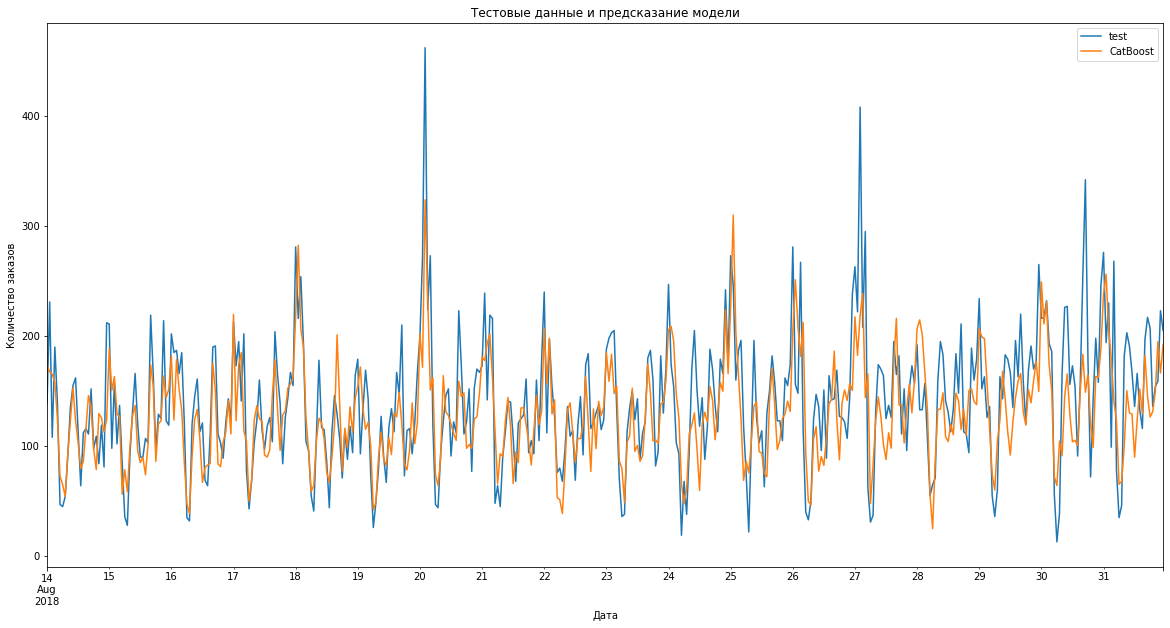

In [28]:
predictions_test.plot(figsize=(20,10))
plt.title('Тестовые данные и предсказание модели')
plt.xlabel('Дата')
plt.ylabel('Количество заказов');

**Вывод**

- На тестовой выборке RMSE упало до 41. Однако это по-прежнему подходит под критерий <48.
- Модель хорошо улавливает тренды, однако плохо реагирует на пиковые значения - как-будто сглаживает их.

# Общий вывод

При выполнении проекта проделана следующая работа:
- Произведена загрузка данных и их подготовка для обучения моделей. Данные представлены периодом с начала марта по конец августа 2018 года.
- За время всех наблюдений наметился восходящий тренд на общее увеличение числа заказов такси в течение часа. Это может быть вызвано общим ростом количества заказов, то есть развитием компании. Однако проверить это можно только имея данные за несколько лет.
- На графиках явно видна суточная сезонность. Ночью количество заказов стремится к нулю, в то время как вечерний час пик - момент самого сильного спроса на услуги такси.
- Я добавил дополнительные признаки - день недели, час, отстающие значения и скользящее среднее. На дополнном датасете подобраны оптимальные гиперпараметры для моделей.
- Обучил четыре модели с оценкой их качества метрикой RMSE. Модели - линейная регрессия, дерево решений, CatBoostRegressor и LGBM.
- Провел тестирование лучшей модели - CatBoost. На тесте RMSE 41 < 48.
- По итогам анализа модели на тестовых данных можно отметить, что модель адекватная. Хорошо ловит тренды, но сглаживает пиковые значения.